# Import packages

In [ ]:
# !pip install -r multiff_analysis/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from neural_data_analysis.topic_based_neural_analysis.target_decoder import target_decoder_class, prep_target_decoder
from data_wrangling import specific_utils, base_processing_class, general_utils

import sys

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import rcca

# To fit gpfa
import numpy as np
import neo
import matplotlib.pyplot as plt
from importlib import reload

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [2]:
reload(target_decoder_class)

<module 'neural_data_analysis.topic_based_neural_analysis.target_decoder.target_decoder_class' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/target_decoder/target_decoder_class.py'>

In [3]:
behav_data_exists_ok = True
x_and_y_var_exists_ok = True

#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
dec = target_decoder_class.TargetDecoderClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.1)
dec.streamline_making_behav_and_neural_data(exists_ok=behav_data_exists_ok)
dec.get_x_and_y_var(exists_ok=x_and_y_var_exists_ok)
dec.get_x_and_y_data_for_modeling(exists_ok=x_and_y_var_exists_ok)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0328/ff_dataframe.h5
Retrieved target_df
Retrieved target_cluster_df
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0328/behav_data_by_point.csv
Loaded single_vis_target_df from all_monkey_data/target_decoder/monkey_Bruno/data_0328/single_vis_target_df.csv
6759 rows of 35984 rows (18.8%) of behav_data_by_bin are preserved after taking out chunks between target last-seen time and capture time
0 segments (0.0%) out of 781 segments have 0 duration. They are dropped from pursuit data

No NA values found in pursuit_data
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0328/binned_spikes_df_0p1.csv
Saved x_var to all_monkey_data/target_decoder/monkey_Bruno/data_0328/target_deco

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

In [4]:
dec.x_var_reduced.columns

Index(['segment', 'bin', 'unit_0', 'unit_1', 'unit_2', 'unit_3', 'unit_4',
       'unit_5', 'unit_6', 'unit_7', 'unit_8', 'unit_9', 'unit_10', 'unit_11',
       'unit_12', 'unit_13', 'unit_14', 'unit_15', 'unit_16', 'unit_17',
       'unit_18', 'unit_19', 'unit_20', 'unit_21'],
      dtype='object')

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.60112 0.36577 0.30222 0.22263 0.2002  0.16506 0.14189 0.12942 0.11875
 0.11354]
% Shared Variance: [0.36134 0.13378 0.09134 0.04956 0.04008 0.02725 0.02013 0.01675 0.0141
 0.01289]


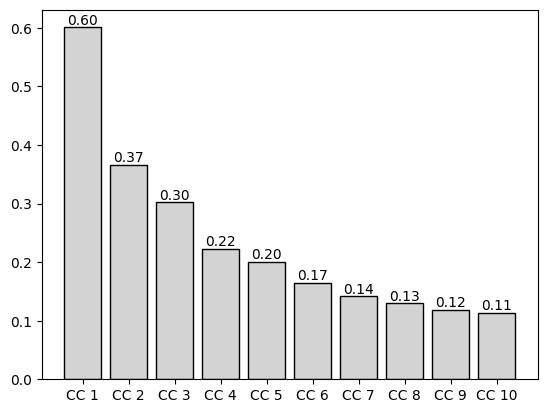

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.8479  0.65596 0.57064 0.5539  0.49691 0.4737  0.4441  0.42595 0.40756
 0.38918]
% Shared Variance: [0.71894 0.43028 0.32563 0.3068  0.24692 0.22439 0.19723 0.18143 0.16611
 0.15146]


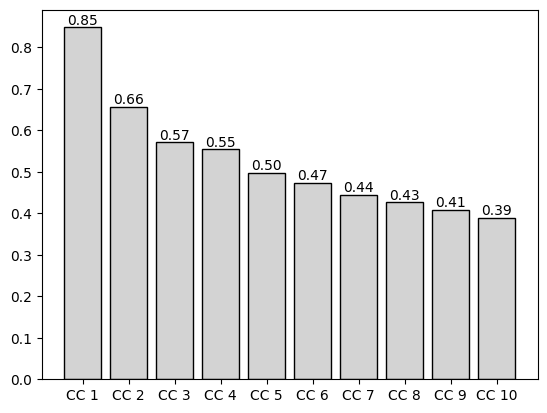

dec.x_var_lags.shape: (6624, 244)
dec.y_var_lags_reduced.shape: (6624, 184)


In [5]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var_reduced.drop(columns=['segment', 'bin'], errors='ignore'), X2=dec.y_var_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

cca_lags = cca_class.CCAclass(X1=dec.x_var_lags_reduced.drop(columns=['segment', 'bin'], errors='ignore'), X2=dec.y_var_lags_reduced, lagging_included=True)
# for all columns that end with _0, rename them to the column name without the _0
cca_lags.X2.columns = cca_lags.X2.columns.str.replace('_0', '')
cca_lags.conduct_cca()


print(f'dec.x_var_lags.shape: {dec.x_var_lags.shape}')
print(f'dec.y_var_lags_reduced.shape: {dec.y_var_lags_reduced.shape}')

cca_inst = cca_lags

## compare lag vs no lag

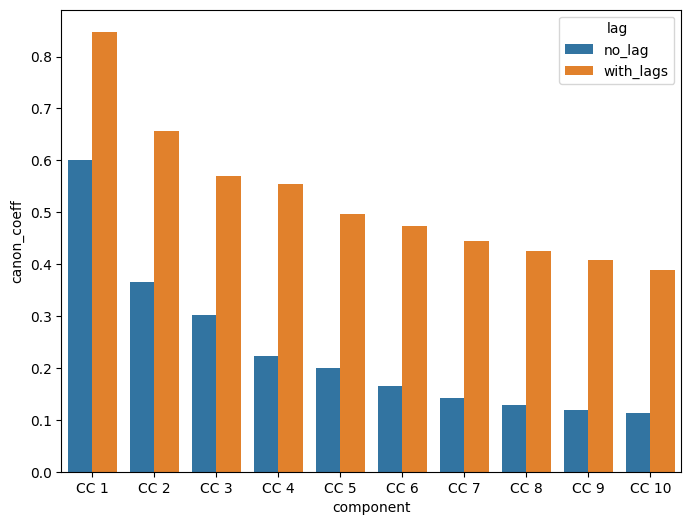

In [6]:
can_load_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
can_load_df[f'with_lags'] = cca_lags.canon_corr
can_load_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert can_load_df to long format
can_load_df_long = pd.melt(can_load_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

# make a sns bar plot on can_load_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=can_load_df_long, hue='lag')
plt.show()

In [7]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## cca_inst (choose one between lags and no lag)

In [ ]:
# choose no lag
cca_inst = cca_no_lag

In [8]:
# choose lags
cca_inst = cca_lags

# Heatmap of loadings

## X1 loadings

                               Cancorr results
    Canonical Correlation Wilks' lambda   Num DF      Den DF   F Value Pr > F
-----------------------------------------------------------------------------
0                  0.8479        0.0000 44528.0000 908069.6377  1.4283 0.0000
1                  0.6560        0.0002 44103.0000 903669.5804  1.2523 0.0000
2                  0.5706        0.0003 43680.0000 899267.4098  1.1801 0.0000
3                  0.5539        0.0005 43259.0000 894863.1107  1.1323 0.0000
4                  0.4969        0.0007 42840.0000 890456.6677  1.0877 0.0000
5                  0.4737        0.0009 42423.0000 886048.0648  1.0551 0.0000
6                  0.4441        0.0011 42008.0000 881637.2862  1.0264 0.0001
7                  0.4259        0.0014 41595.0000 877224.3154  1.0024 0.3643
8                  0.4076        0.0017 41184.0000 872809.1358  0.9811 0.9961
9                  0.3892        0.0021 40775.0000 868391.7305  0.9623 1.0000
10               

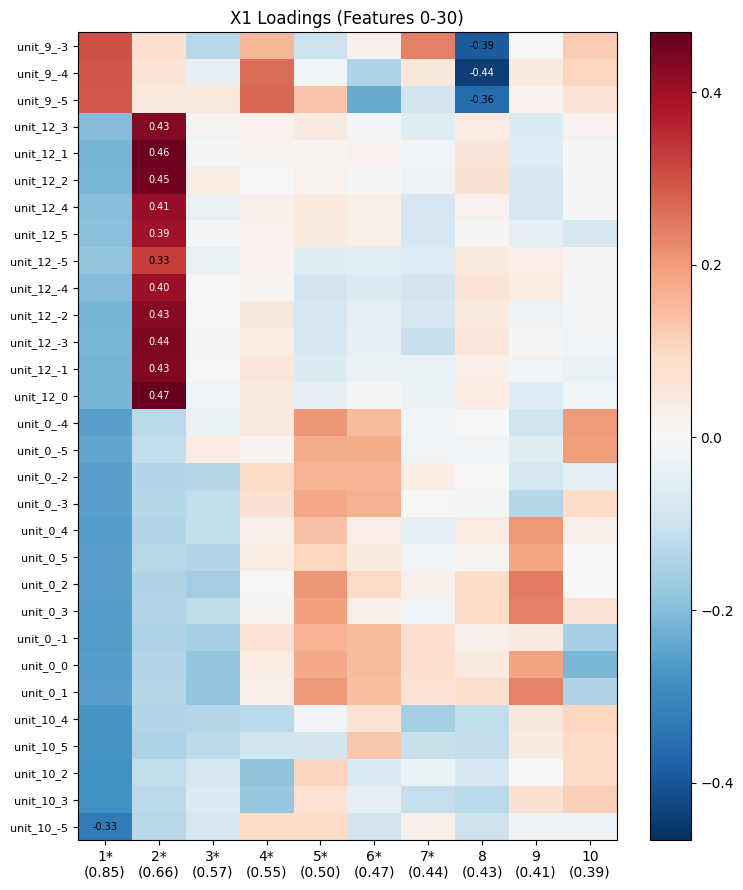

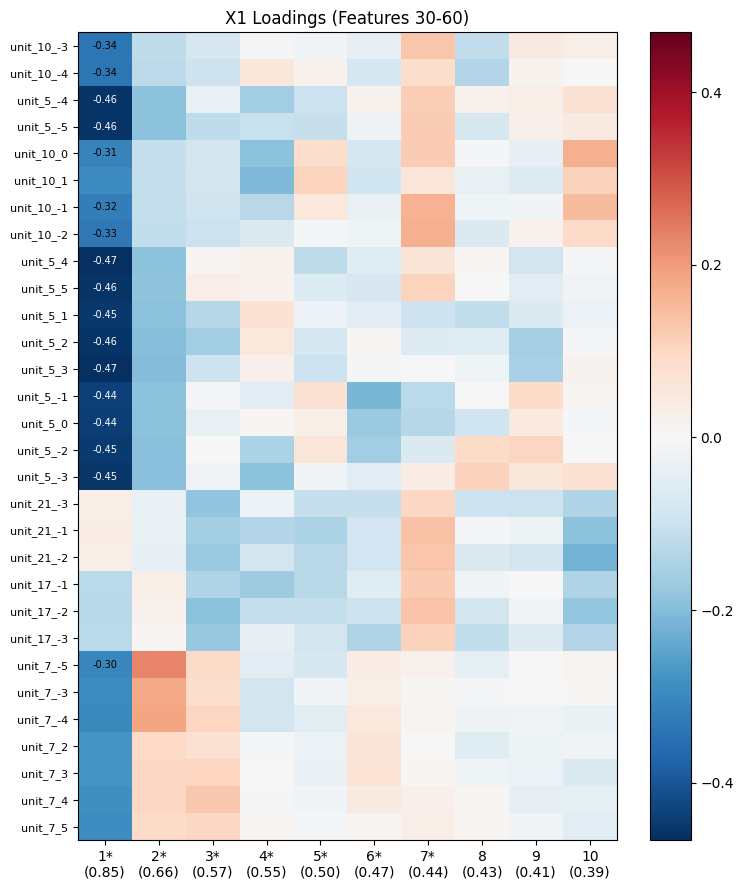

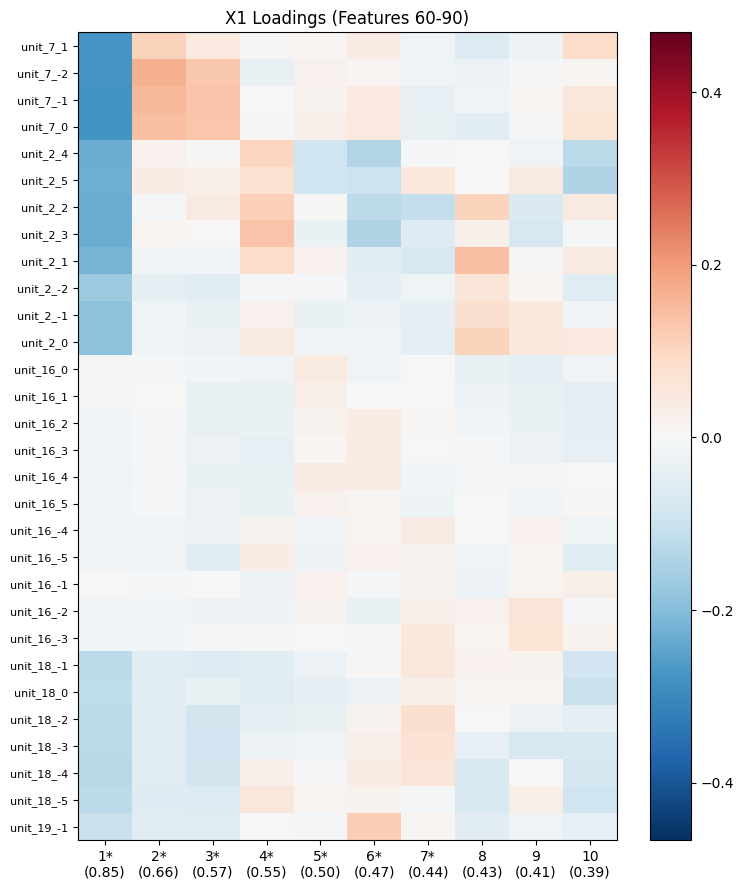

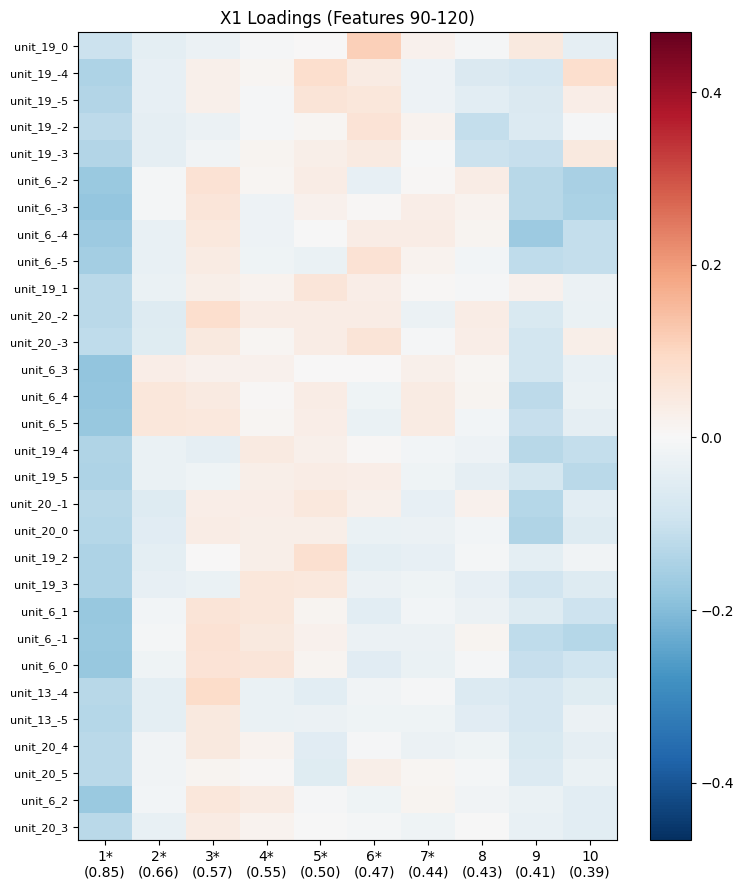

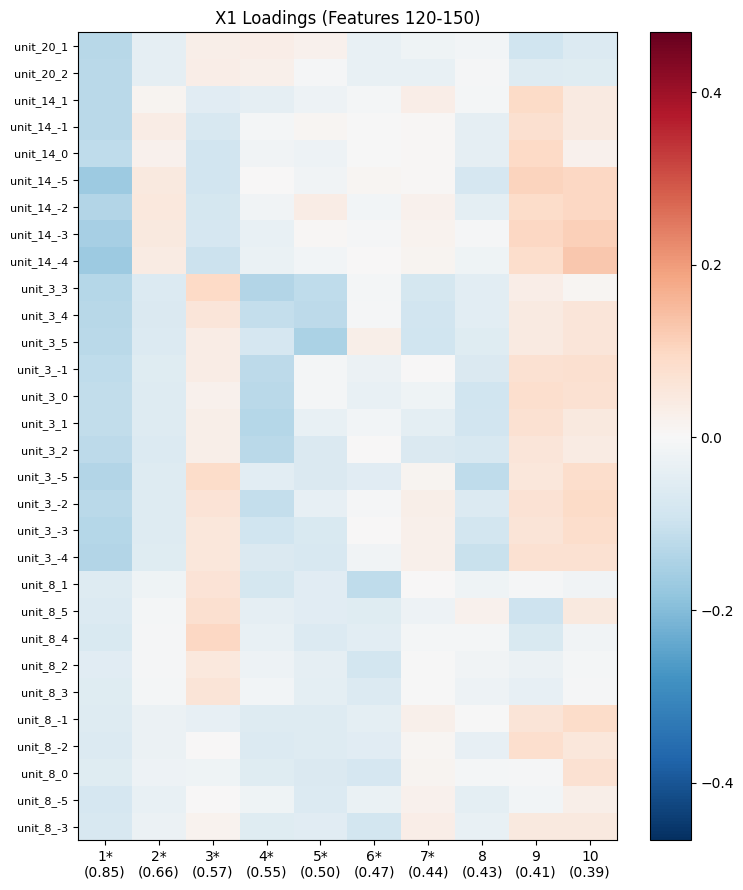

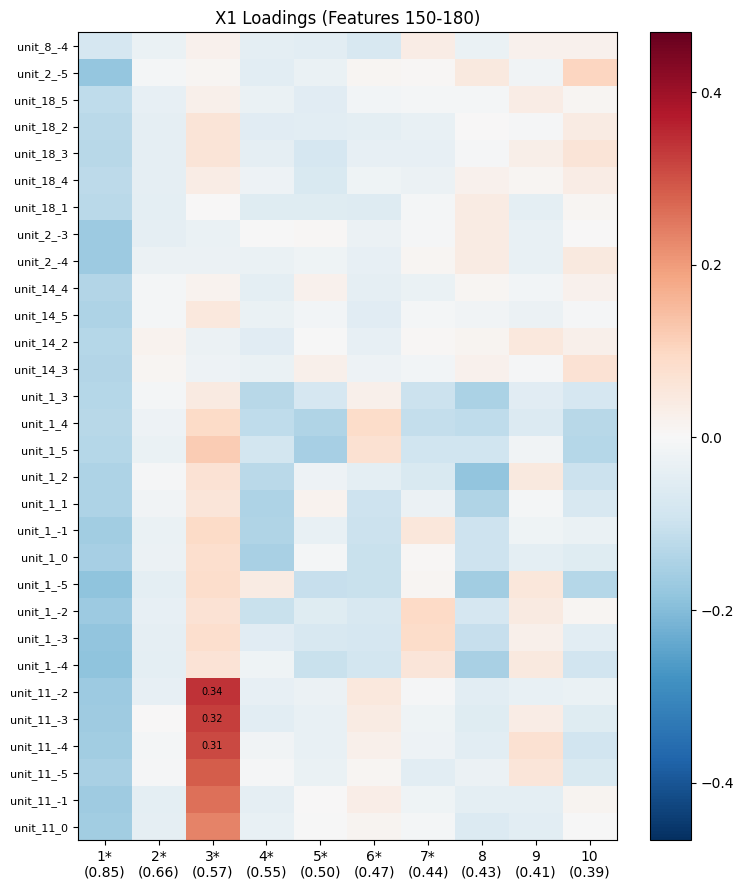

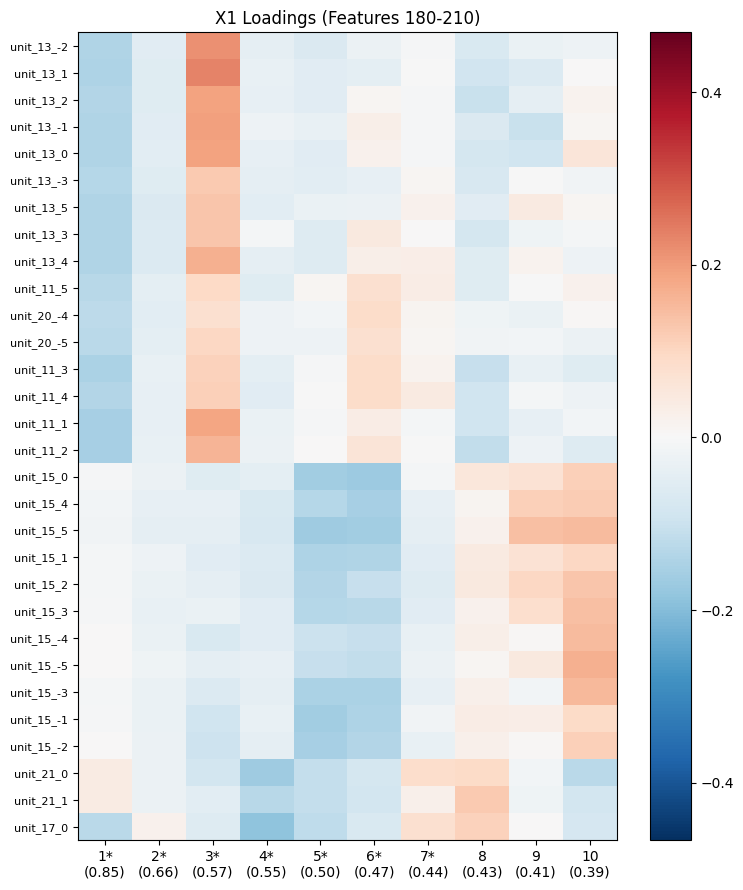

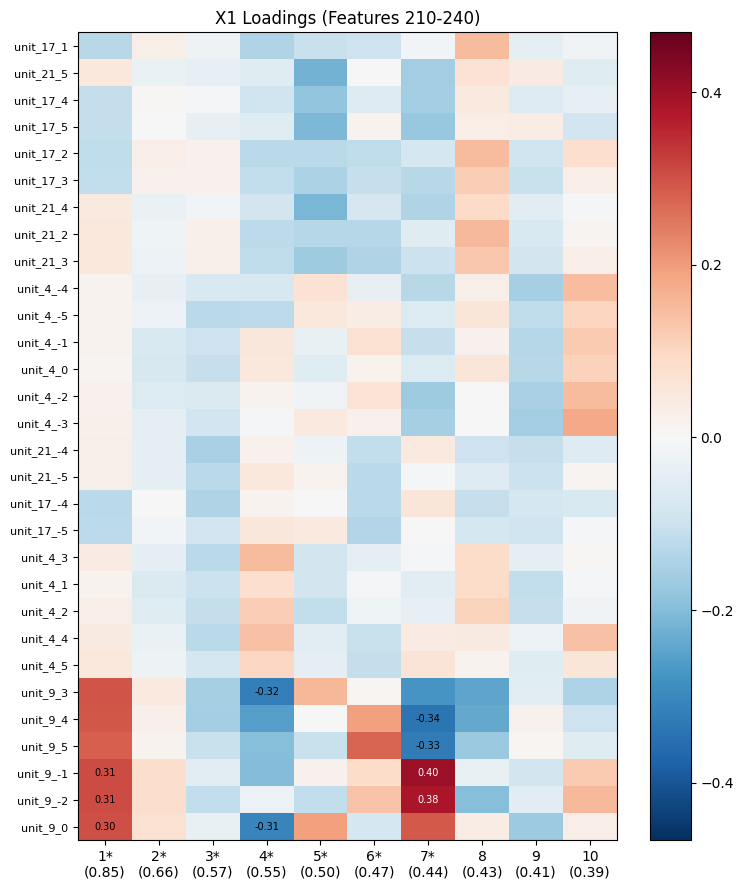

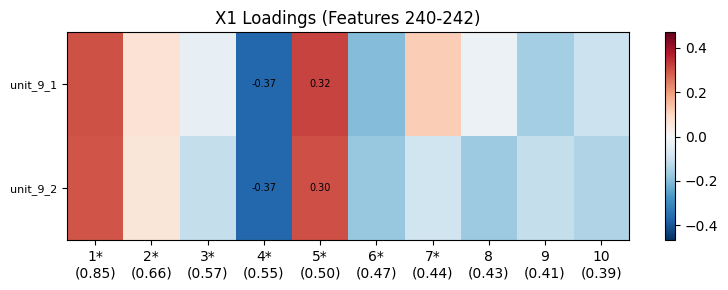

In [10]:
cca_inst.plot_X1_loadings()

## X2 loadings

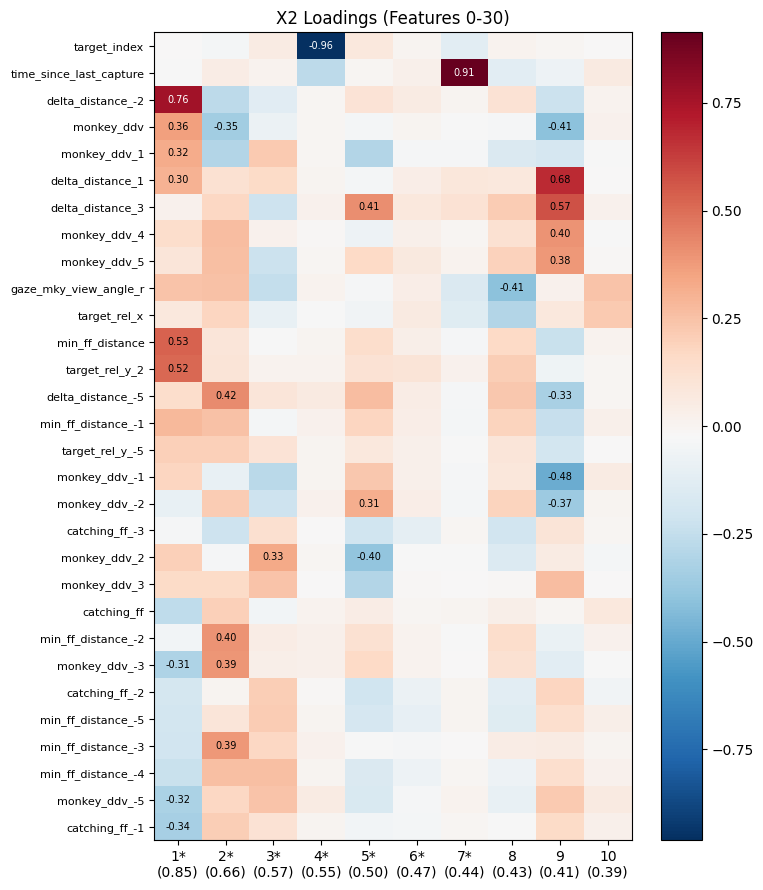

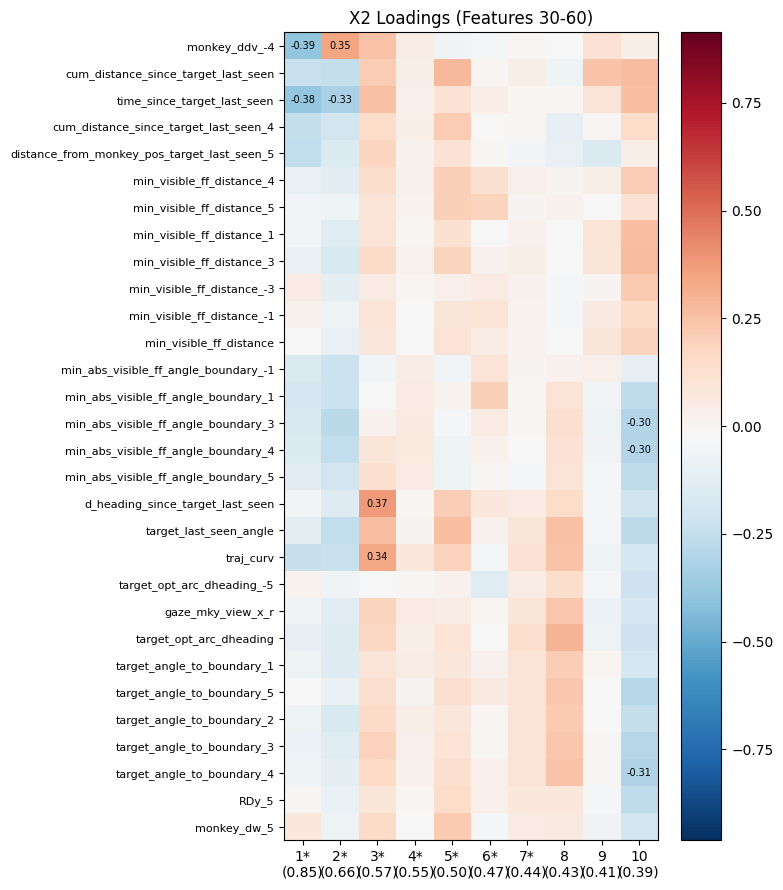

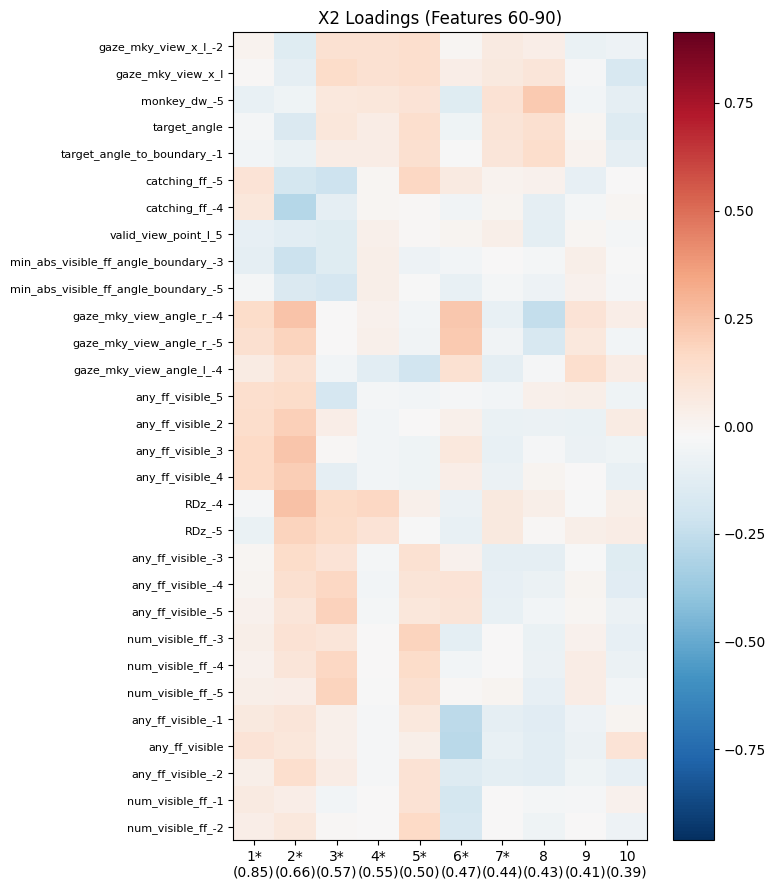

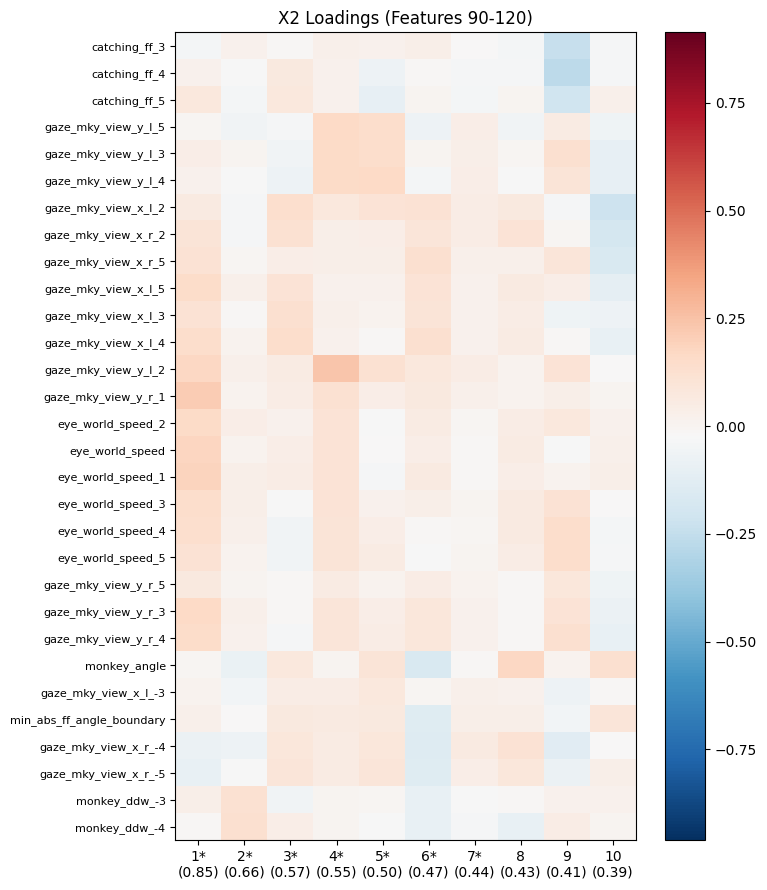

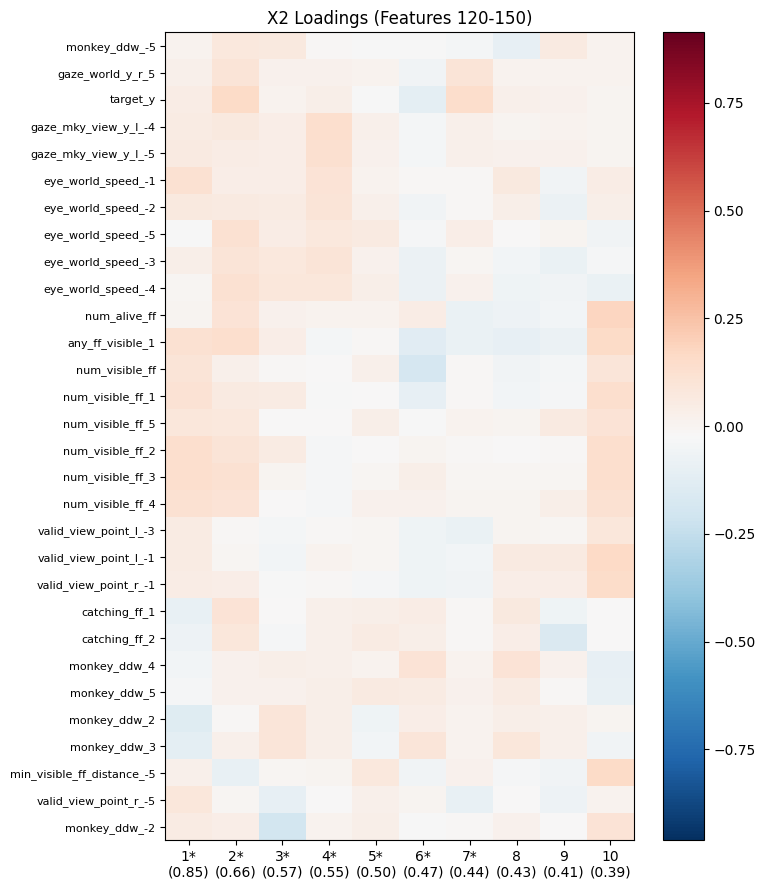

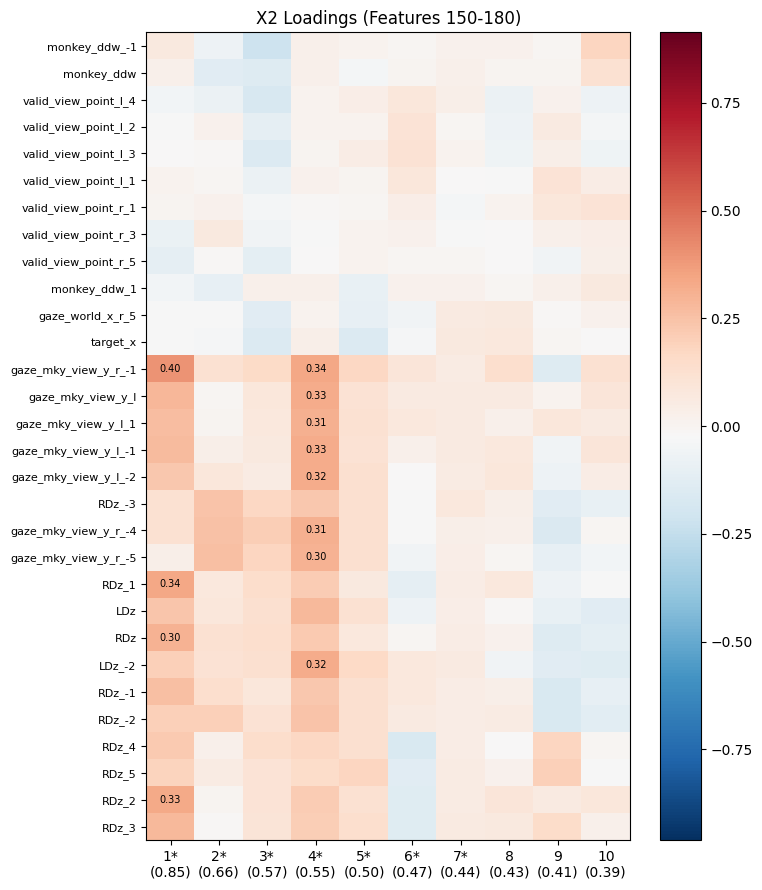

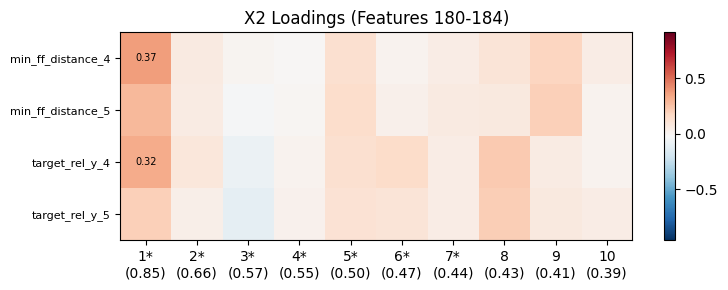

In [11]:
cca_inst.plot_X2_loadings()

In [ ]:
stop!

# Canonical Variate scatterplots

In [ ]:
components=range(1, 5)
cca_plotting.plot_cca_component_scatter(cca_inst.X1_c, cca_inst.X2_c, components=components, show_y_eq_x=True)


# Test for p values

In [ ]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

# Transform vars (e.g. use basis functions)

In [ ]:
cca_no_lag.X2_tf_df = transform_vars.transform_behav_data(cca_no_lag.X2)
cca_lags.X2_tf_df = transform_vars.transform_behav_data(cca_lags.X2)

In [ ]:
# If need to use the data
cca_inst = cca_lags
X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_tf_df


# Lags vs no lag & train vs test

## Get data

In [ ]:
combined_cross_view_df, combined_can_load_df = cca_cv_utils.combine_cca_cv_results(cca_no_lag, cca_lags, n_components=7, reg=0.1, n_splits=7,
                                                                               #groups=pn.y_var['segment'].values
                                                                               )

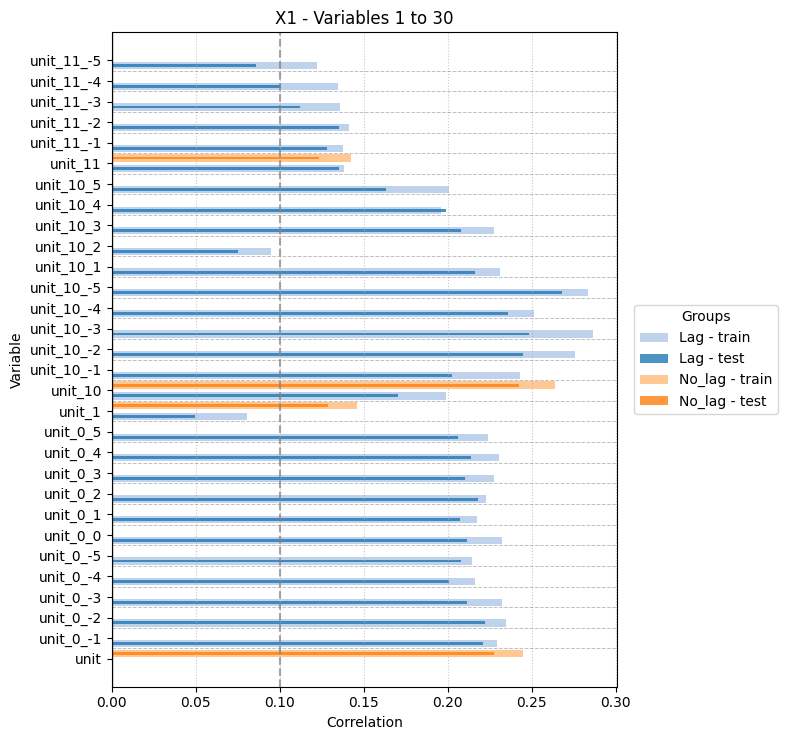

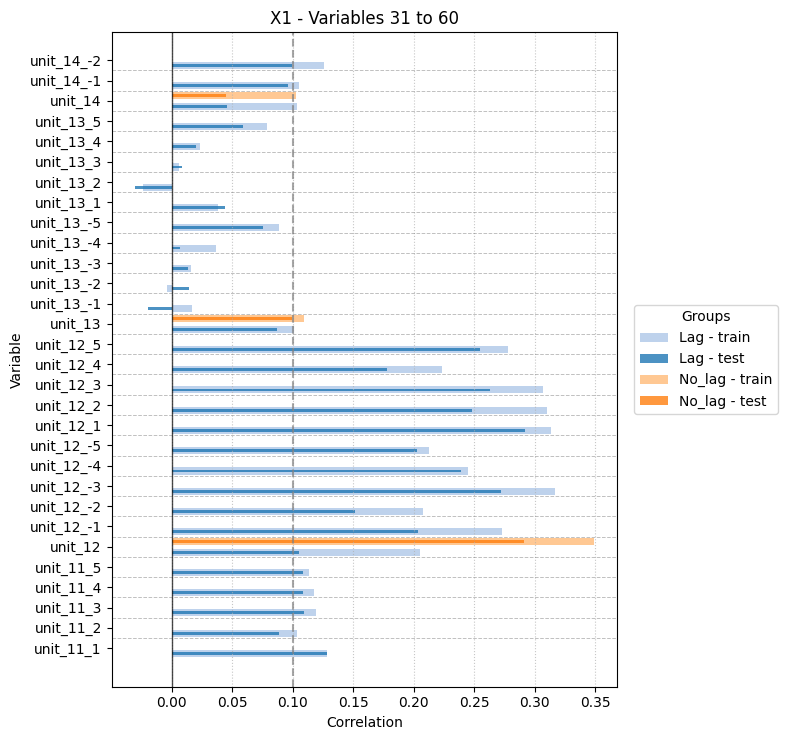

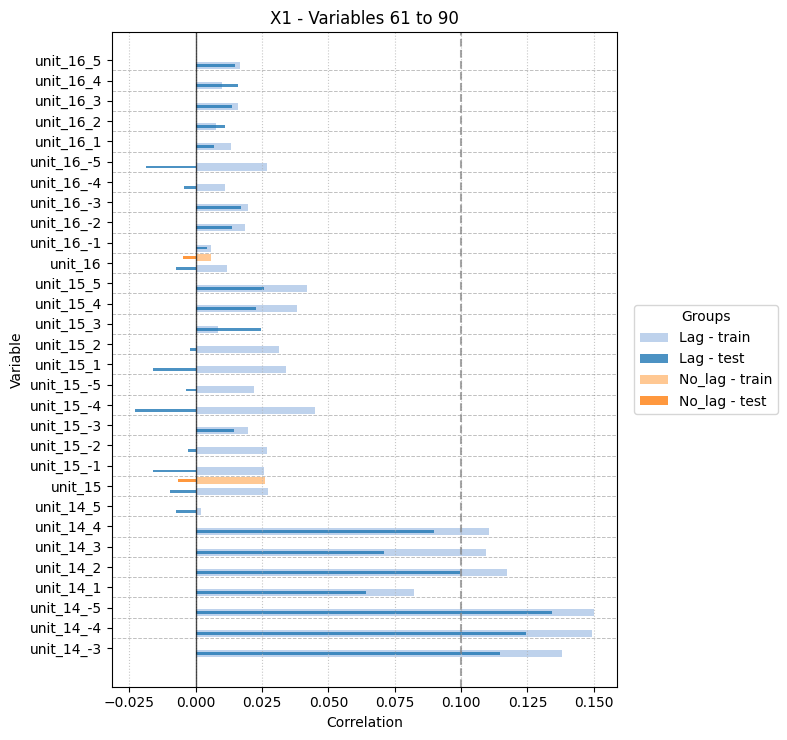

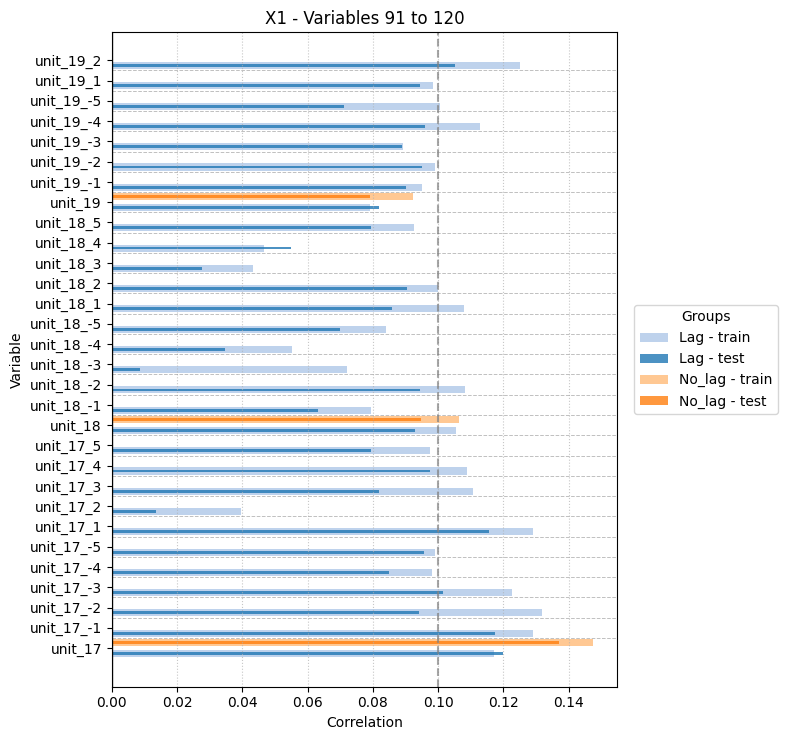

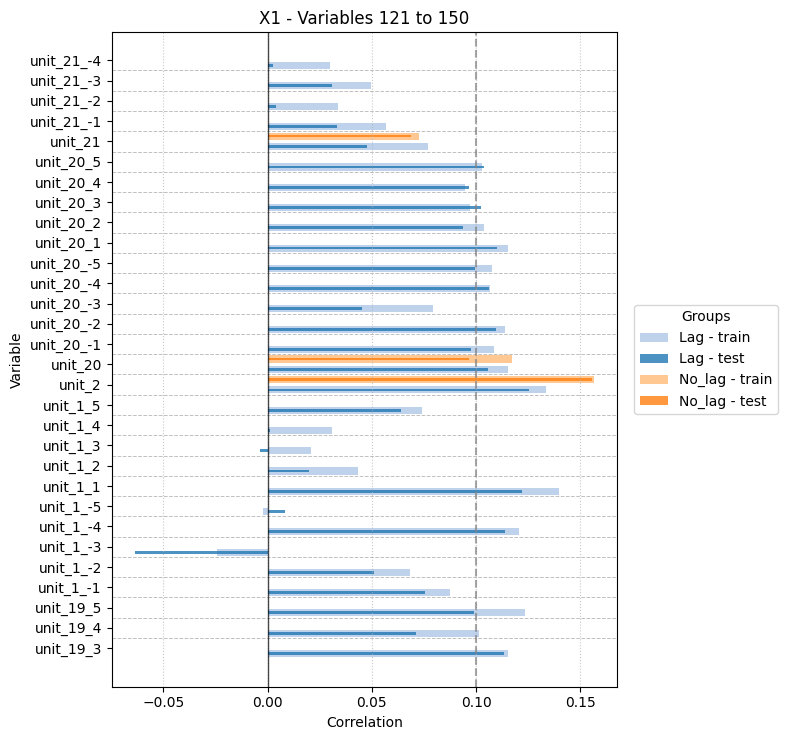

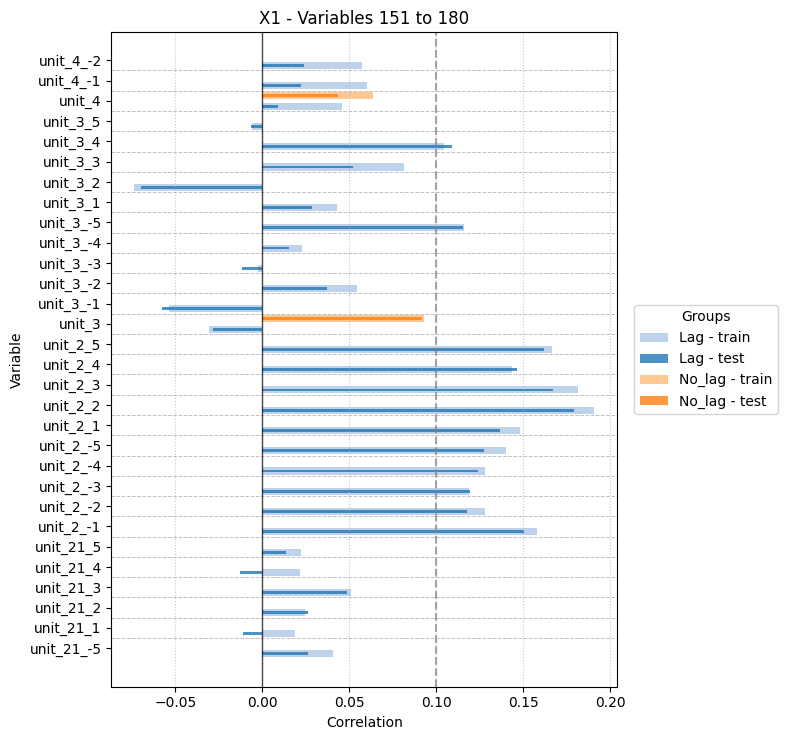

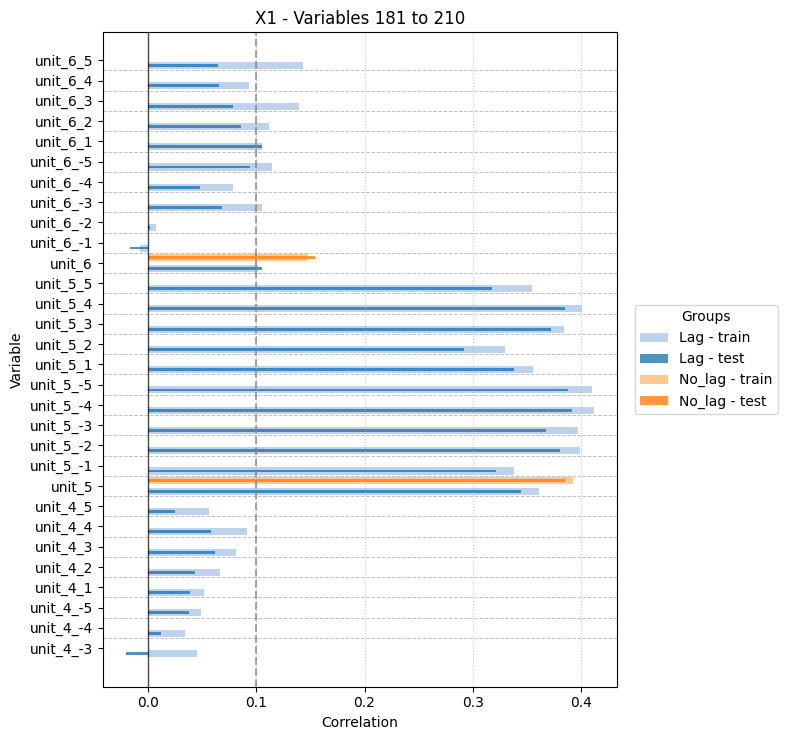

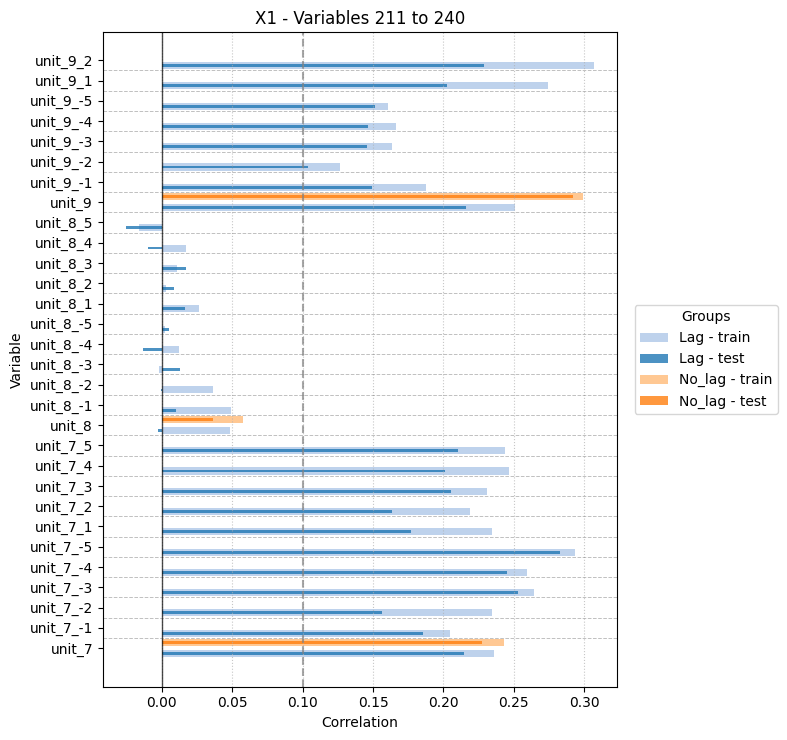

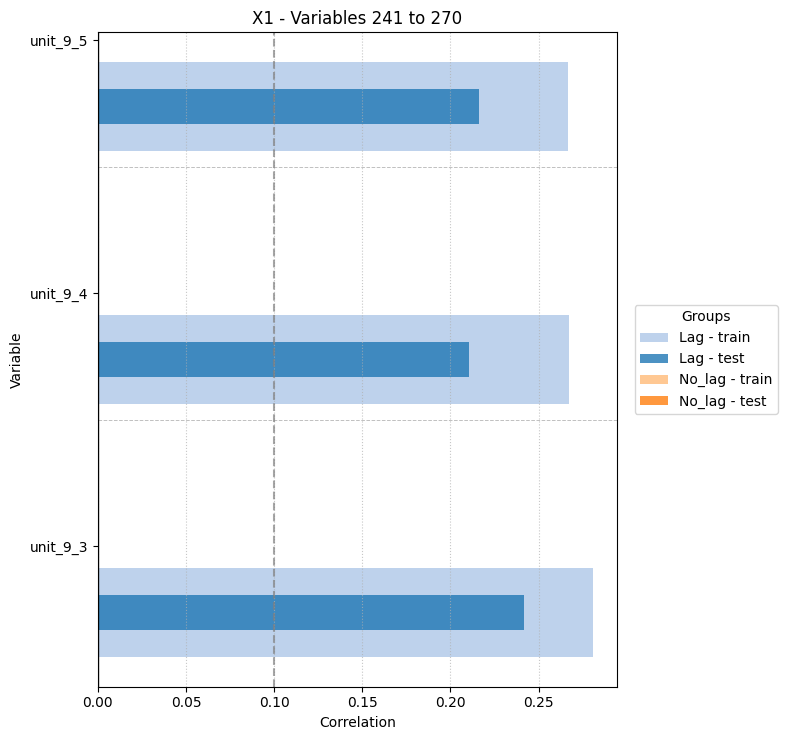

In [13]:
dataset_name = 'X1'
cross_view_sub = combined_cross_view_df[combined_cross_view_df['dataset'] == dataset_name]
cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(cross_view_sub, dataset_name, mode='lag_offset')


## cross-view X2

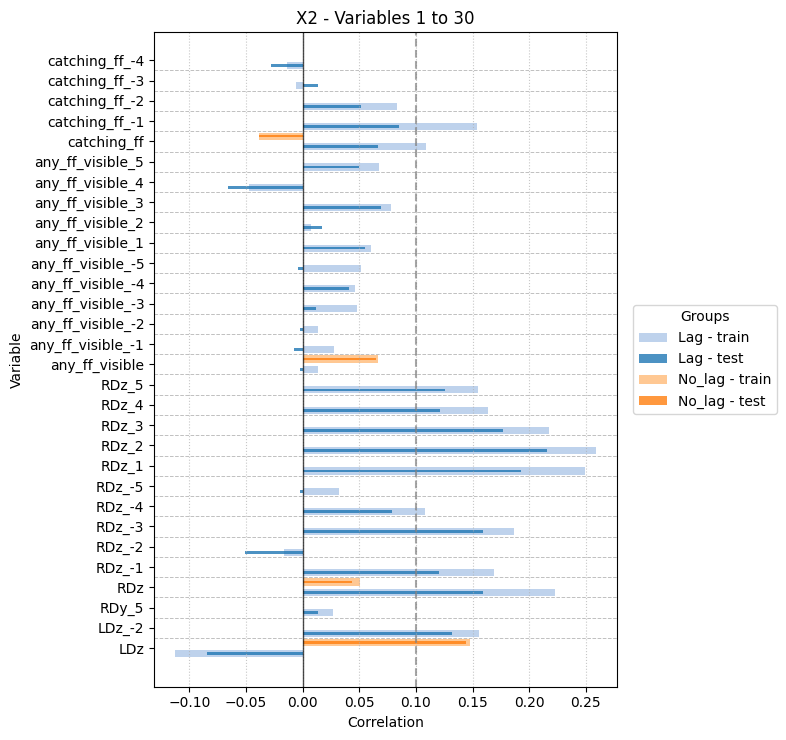

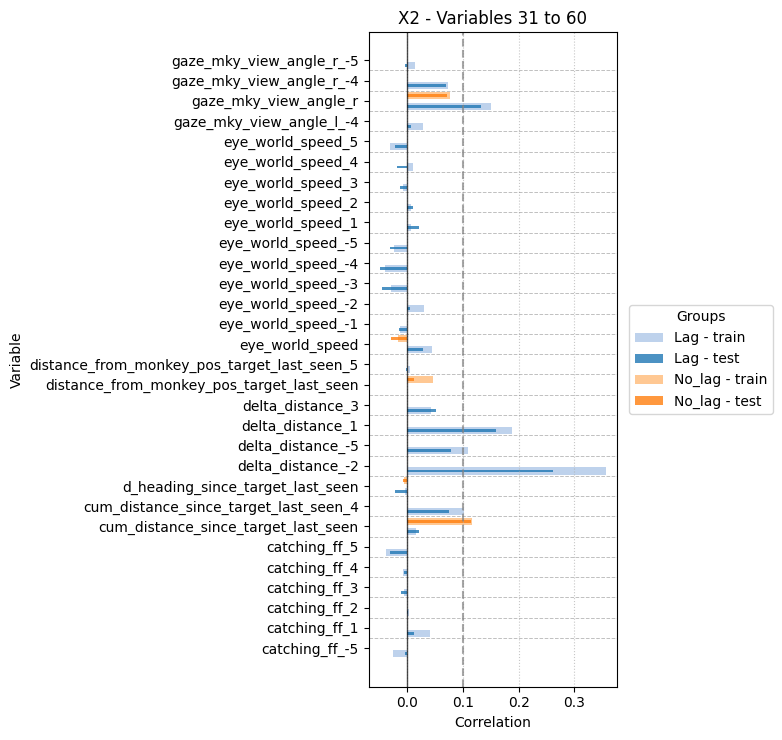

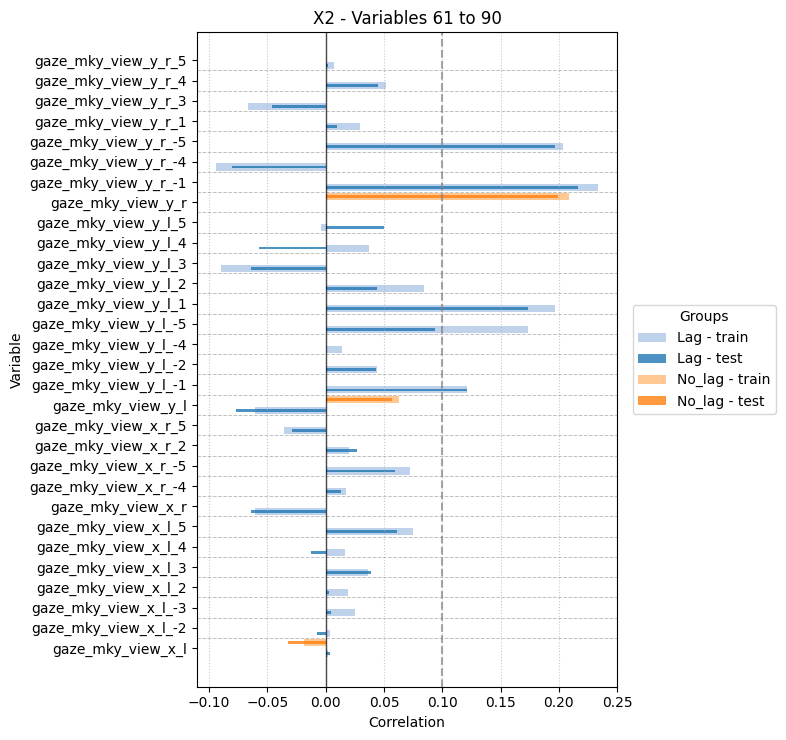

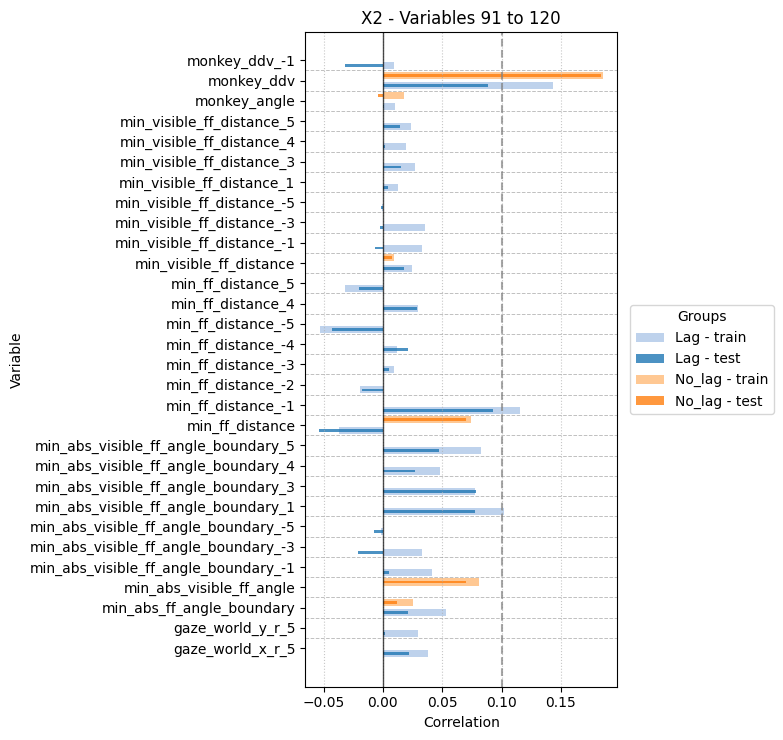

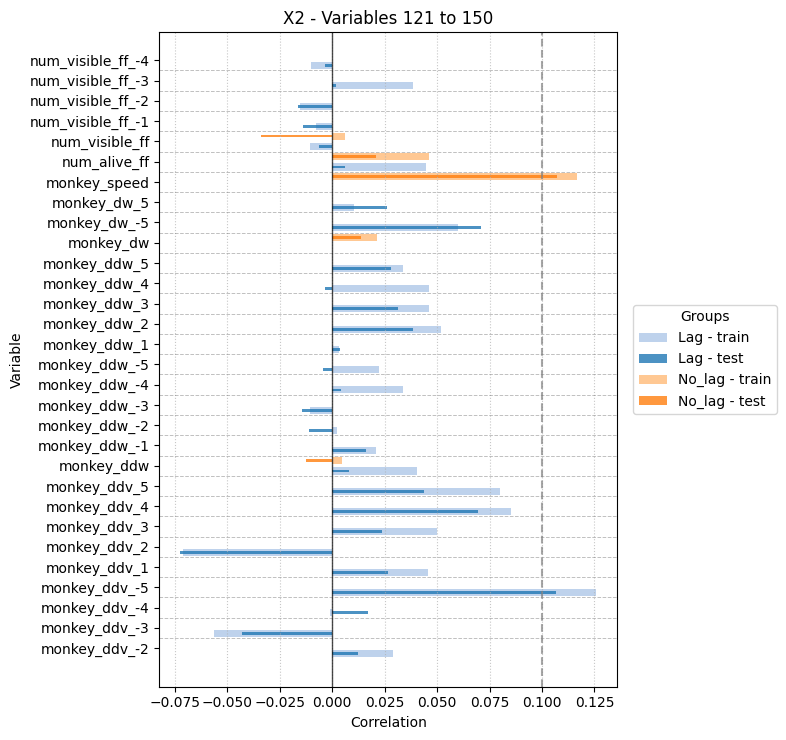

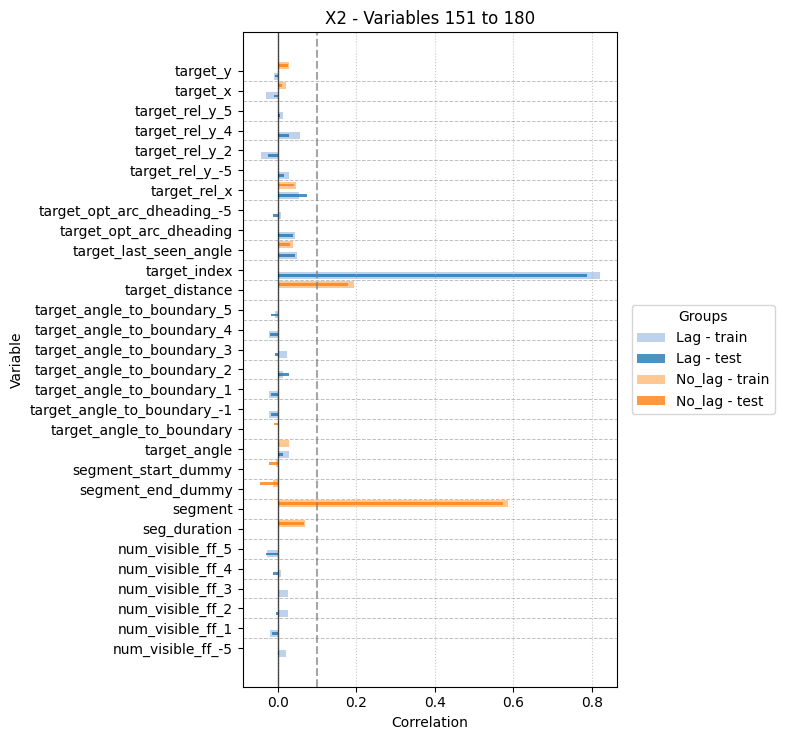

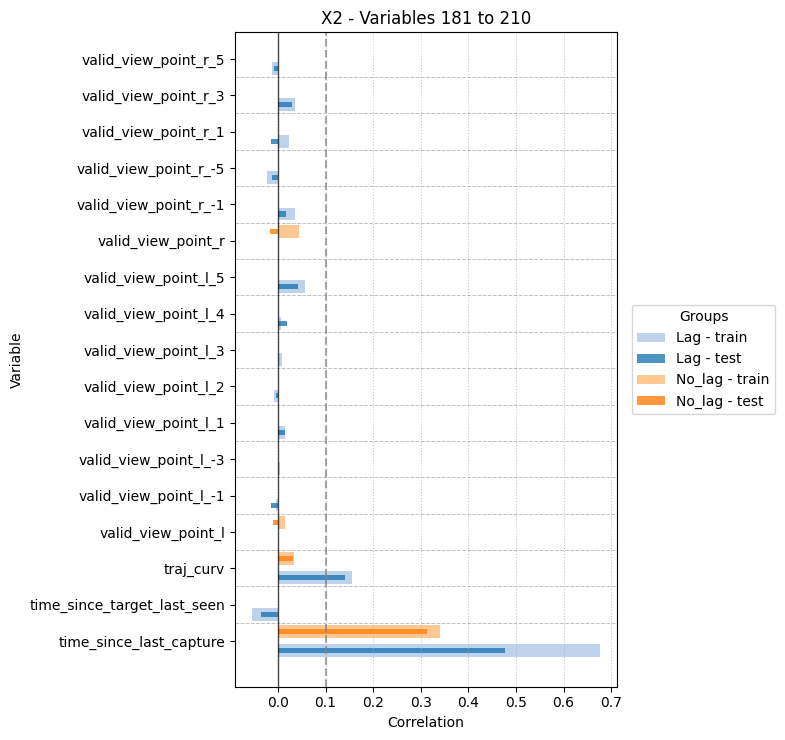

In [14]:
dataset_name = 'X2'
cross_view_sub = combined_cross_view_df[combined_cross_view_df['dataset'] == dataset_name]
cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(cross_view_sub, dataset_name, mode='lag_offset')


## loading X1

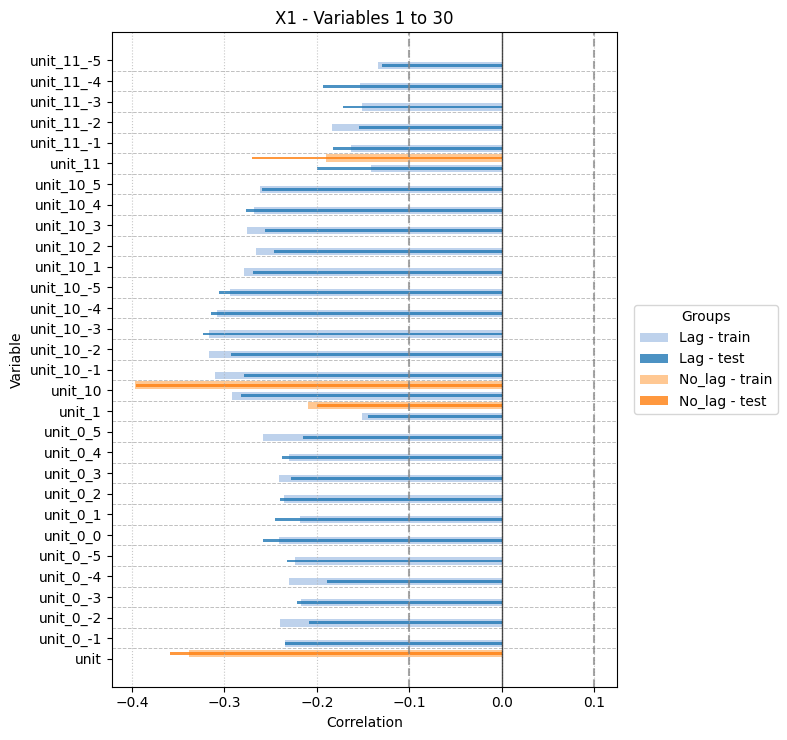

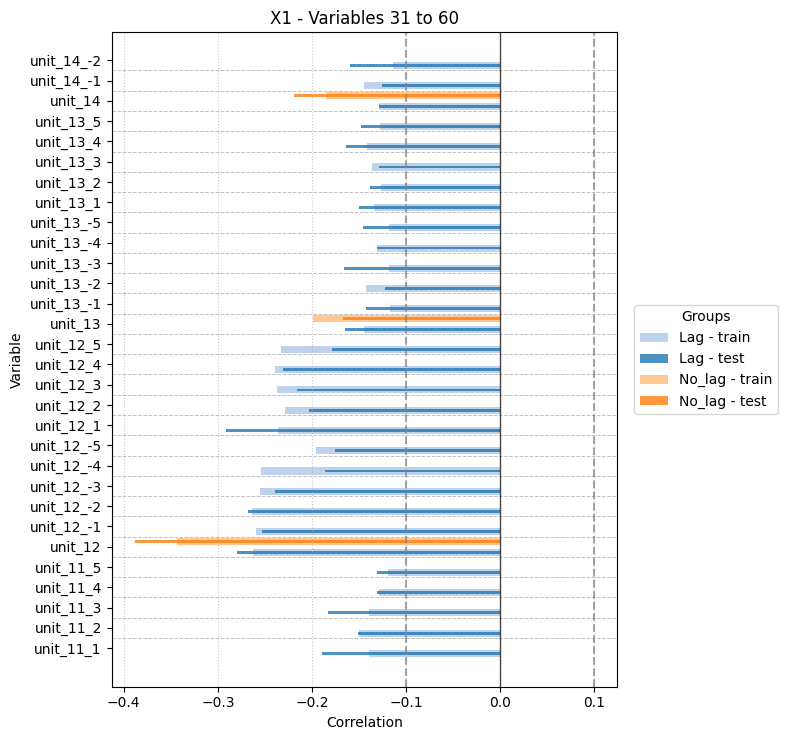

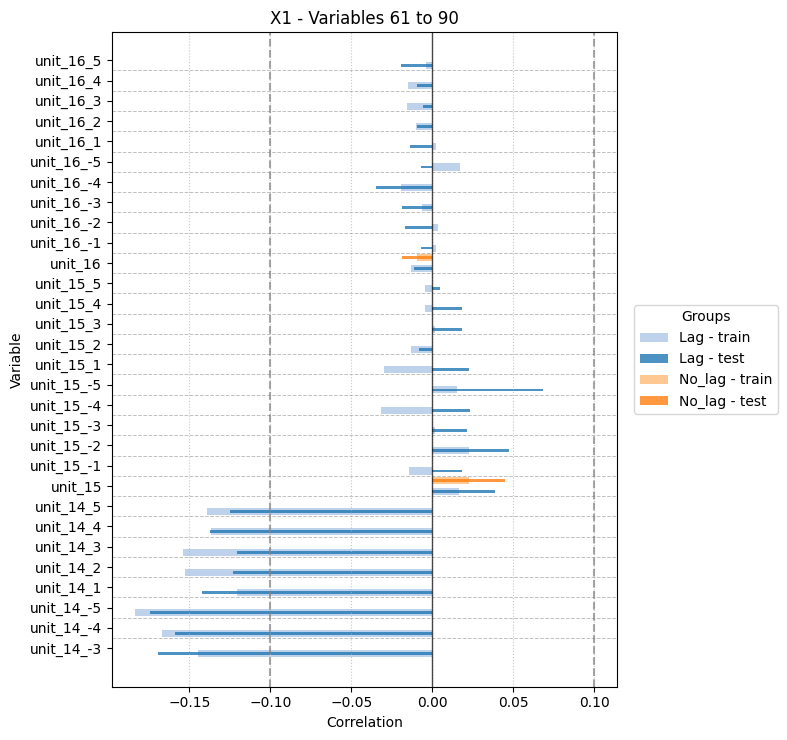

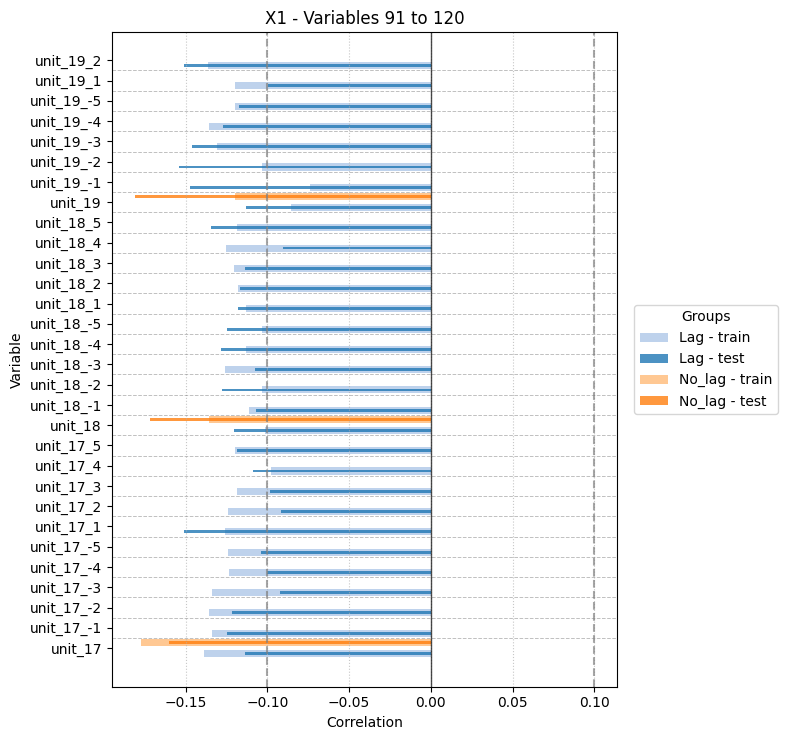

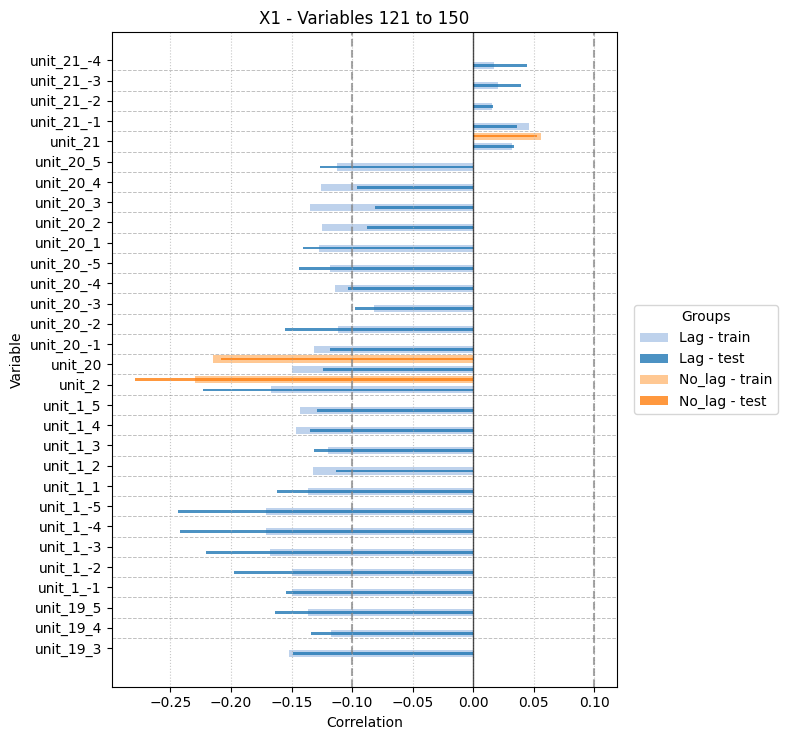

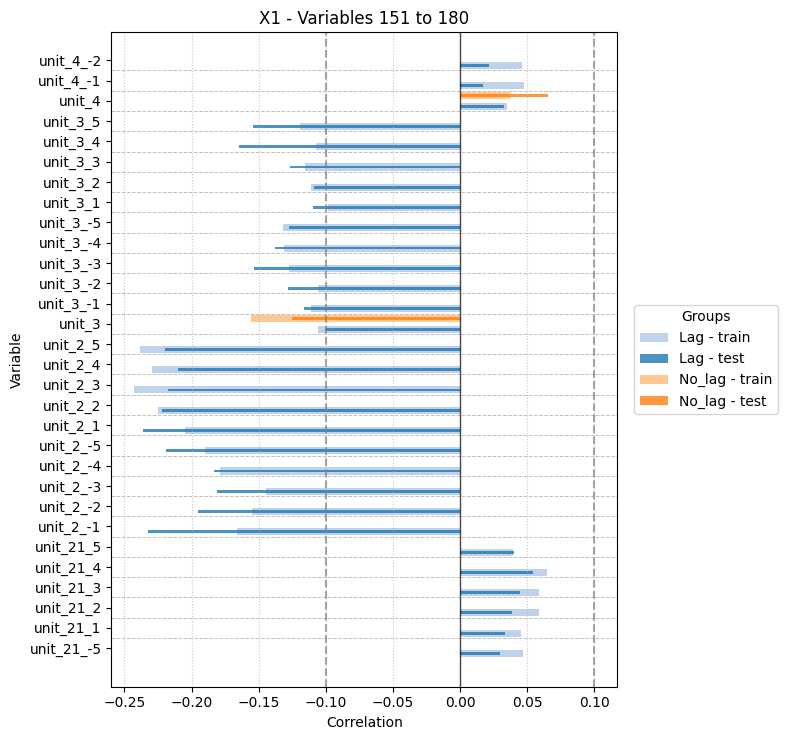

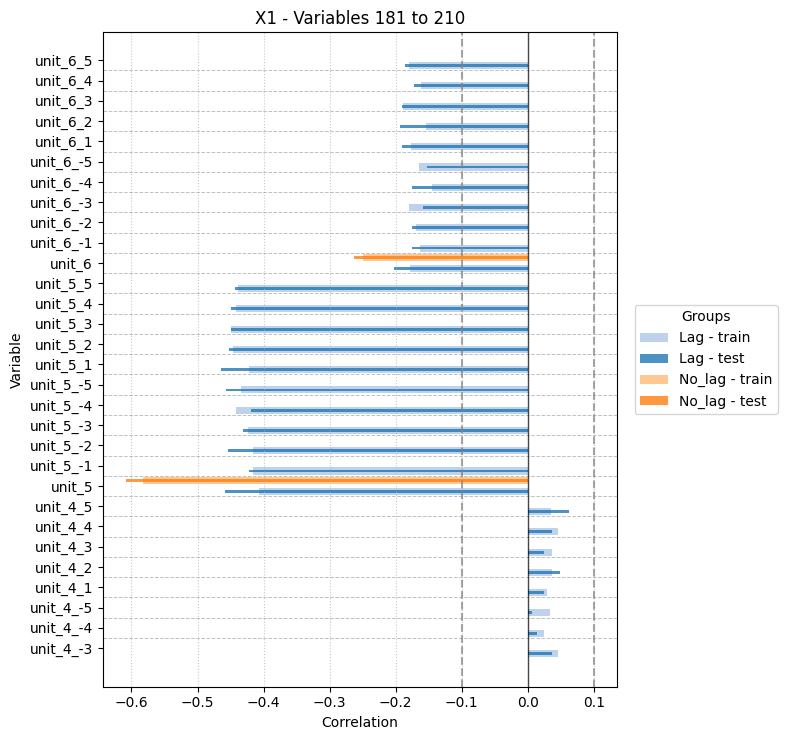

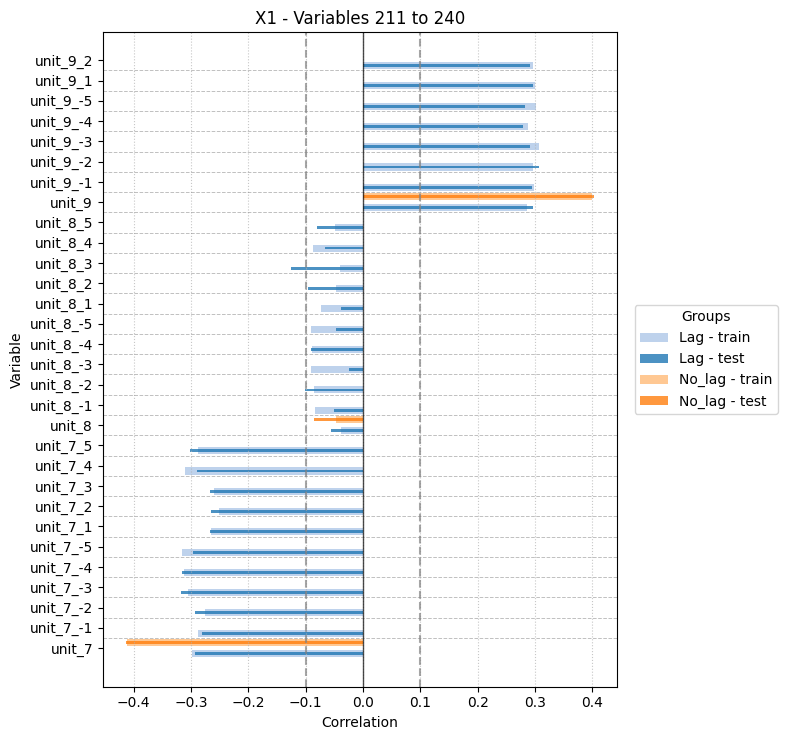

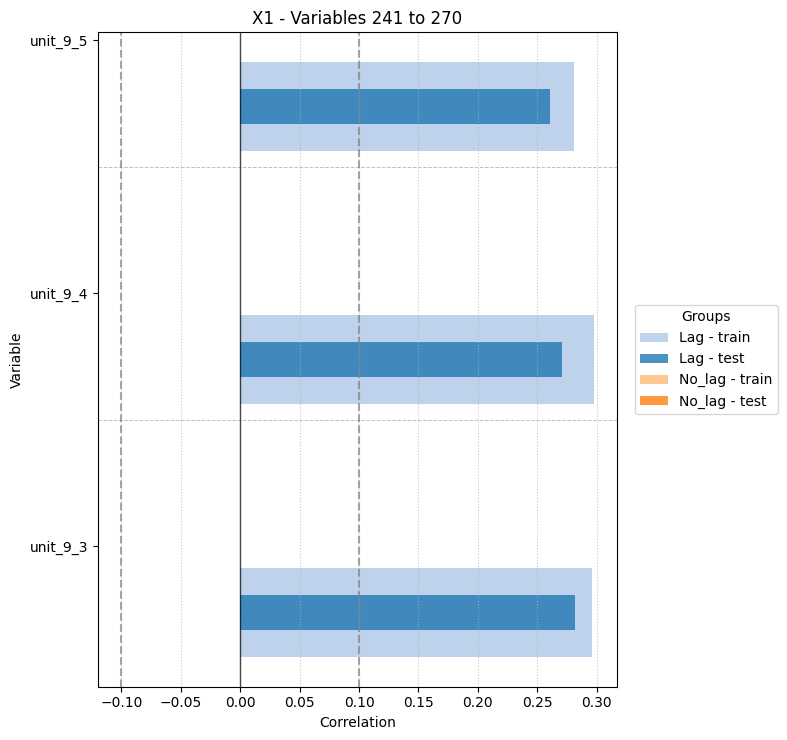

In [15]:
dataset_name = 'X1'
canon_comp = 1
can_load_df_sub = combined_can_load_df[combined_can_load_df['dataset'] == dataset_name]
can_load_df_sub = can_load_df_sub[can_load_df_sub['canonical_component'] == canon_comp]
cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(can_load_df_sub, dataset_name, mode='lag_offset')


## loading X2

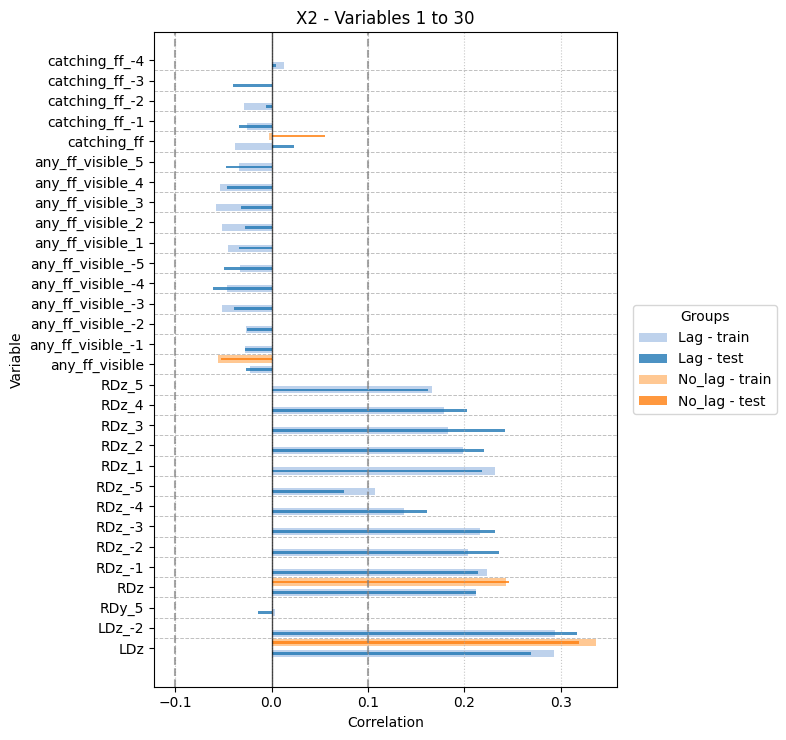

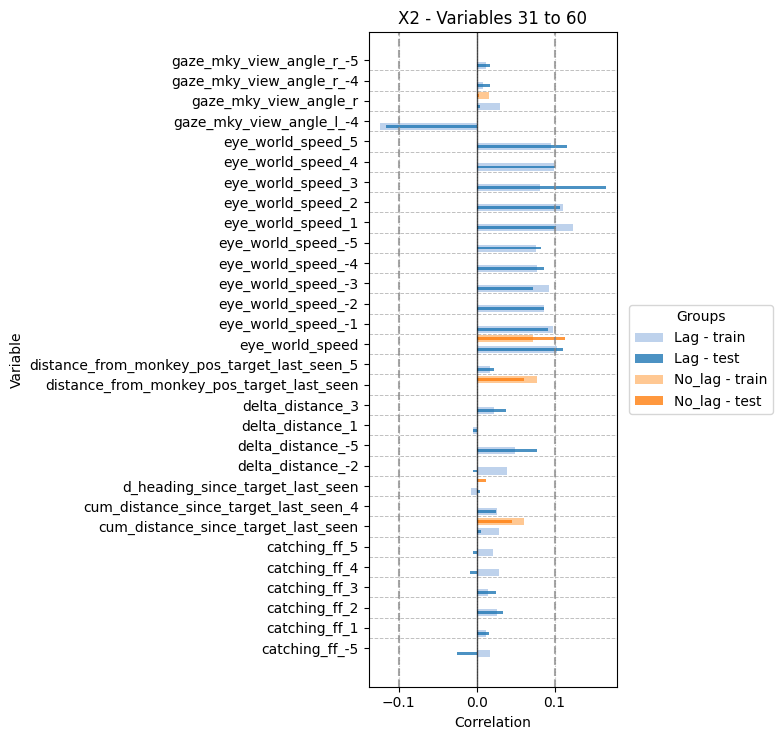

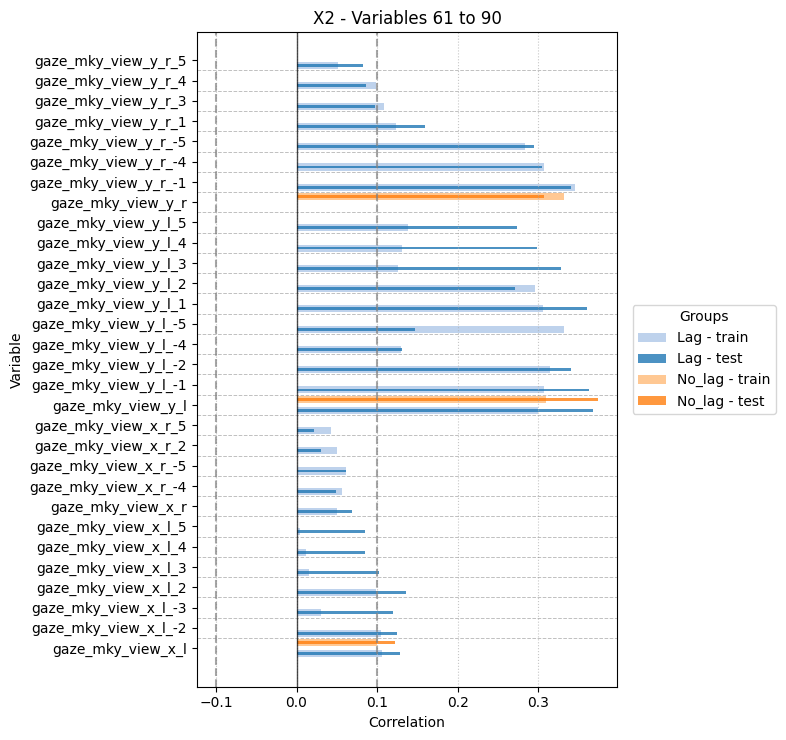

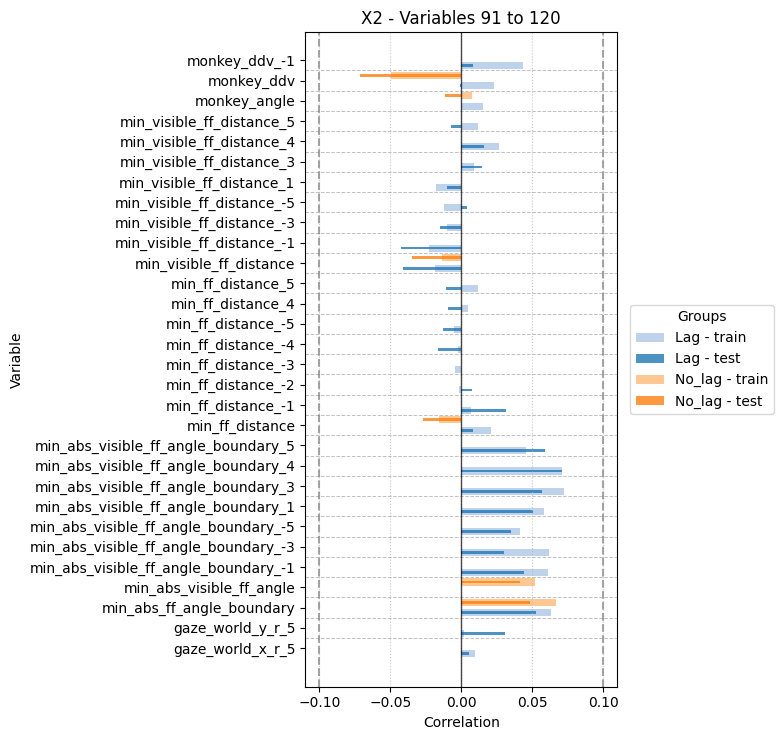

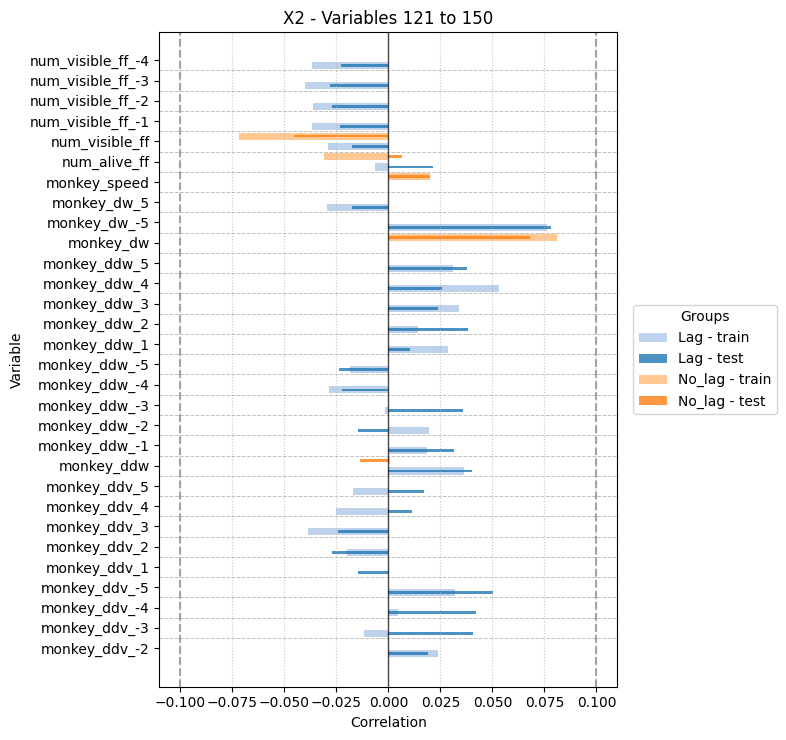

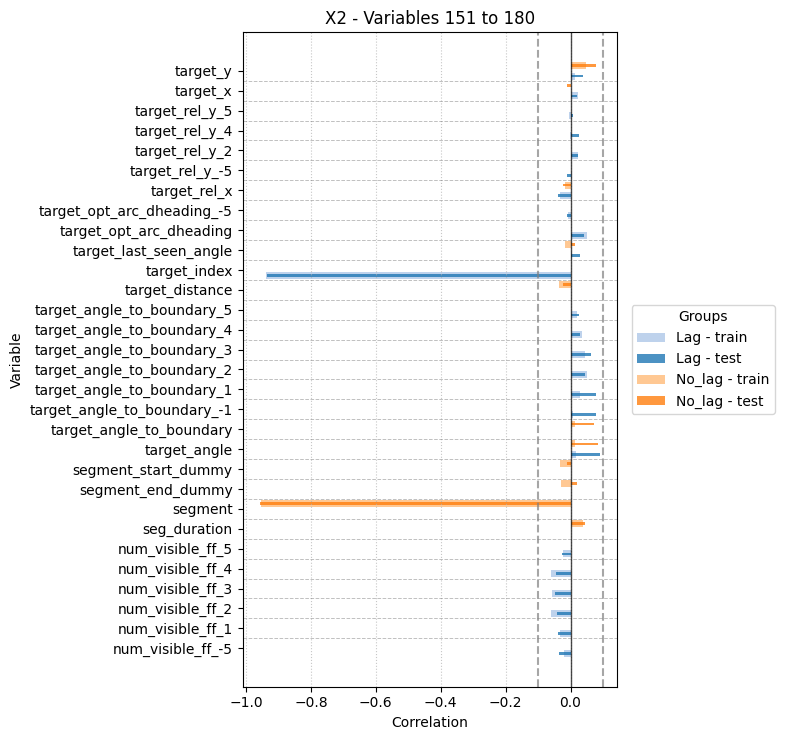

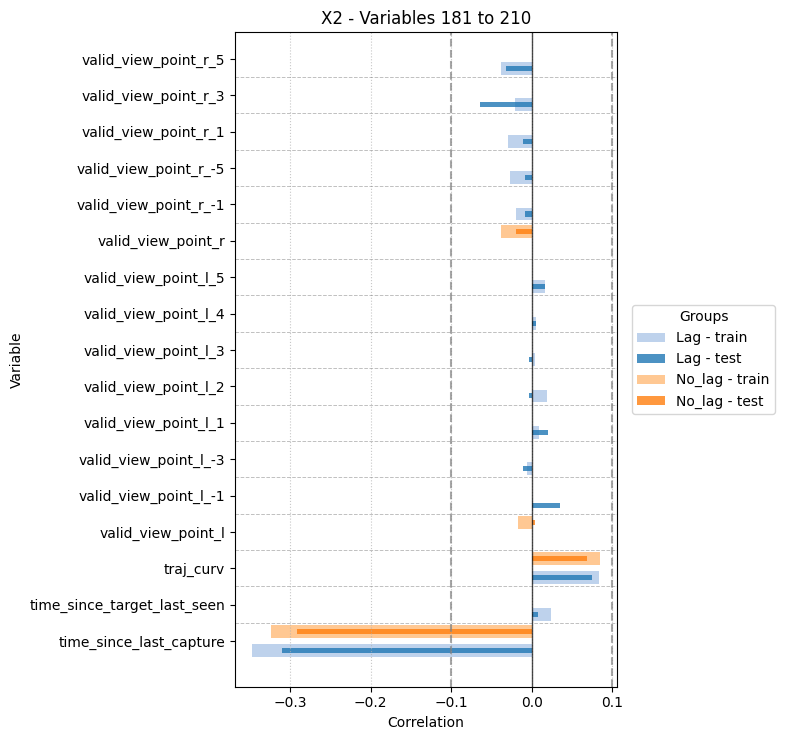

In [16]:
dataset_name = 'X2'
canon_comp = 1
can_load_df_sub = combined_can_load_df[combined_can_load_df['dataset'] == dataset_name]
can_load_df_sub = can_load_df_sub[can_load_df_sub['canonical_component'] == canon_comp]
cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(can_load_df_sub, dataset_name, mode='lag_offset')


In [17]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

# Just train vs test

In [ ]:
filter_significant = True
sort_by_significance = True

## cross-view X1

In [ ]:
significance_threshold = 4
whether_lag = 'no_lag'

combined_cross_view_df_sub = combined_cross_view_df[combined_cross_view_df['whether_lag'] == whether_lag]

# X1
cca_plot_cv.plot_cca_cv_results(combined_cross_view_df_sub, data_type='X1',
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


## cross-view X2

In [ ]:
significance_threshold = 4
whether_lag = 'no_lag'

combined_cross_view_df_sub = combined_cross_view_df[combined_cross_view_df['whether_lag'] == whether_lag]

# X2
cca_plot_cv.plot_cca_cv_results(combined_cross_view_df_sub, data_type='X2',
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


## loading X1

In [ ]:
component = 1
significance_threshold = 1

combined_can_load_df_sub = combined_can_load_df[combined_can_load_df['whether_lag'] == 'no_lag']

# X1
cca_plot_cv.plot_cca_cv_results(combined_can_load_df_sub, data_type='X1', component=component, 
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)

## loading X2

In [ ]:
component = 1
significance_threshold = 1

combined_can_load_df_sub = combined_can_load_df[combined_can_load_df['whether_lag'] == 'no_lag']

# X2
cca_plot_cv.plot_cca_cv_results(combined_can_load_df_sub, data_type='X1', component=component, 
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)

# Barplots of loadings/weights

## loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## weights (ranked)

### neurons

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

## abs weights ranked

### neurons

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

In [ ]:
stop here!

# Distribution of each feature

In [ ]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

In [ ]:
max_plot_to_make = 3

counter = 0
for column in X2_sc_df.columns:
    counter += 1
    if counter > max_plot_to_make:
        break
    
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

# Appendix

## thoughts: could you use neural data to decode target position?

what about 2nd target's position?
(can either use 1st target's decoder, or train and separate decoder for 2nd target)

## other potential transformers to use

In [ ]:
transformers = [
    ('identity', lambda x: x),
    ('log_signed', lambda x: np.log1p(np.abs(x)) * np.sign(x)),
    ('poly', lambda x: np.hstack([x**p for p in [1, 2, 3]])),
    ('sqrt_signed', lambda x: np.sqrt(np.abs(x)) * np.sign(x)),
    ('rank_gauss', rank_gauss_transform)  # optional custom
]


## check NA

In [ ]:
general_utils.check_na_in_df(cca_inst.X2_sc_df)

In [ ]:
general_utils.check_array_integrity(X_t, name="Array", top_n=10, verbose=True)

## permutation test (later)

In [ ]:
import numpy as np
from tqdm import tqdm

n_permutations = 1000
component = 0  # which canonical component
n_features = X1.shape[1]

# Store observed loadings
observed_loadings = mean_X1_test[:, component]  # or use your preferred estimate

# Store null distributions
null_loadings = np.zeros((n_features, n_permutations))

for perm in tqdm(range(n_permutations)):
    # Shuffle rows of X1
    X1_perm = np.random.permutation(X1)
    # Fit CCA on permuted X1 and original X2
    cca2 = rcca.CCA(kernelcca=False, reg=0.1, numCC=nComponents)
    cca2.train([X1_perm, X2])
    U_perm = np.dot(X1_perm, cca2.ws[0])
    # Compute loadings for permuted data
    load_X1_perm = np.corrcoef(X1_perm.T, U_perm.T)[:n_features, n_features:]
    null_loadings[:, perm] = load_X1_perm[:, component]

# Compute two-sided p-values
p_values = np.mean(np.abs(null_loadings) >= np.abs(observed_loadings[:, None]), axis=1)

In [ ]:
import matplotlib.pyplot as plt

alpha = 0.05  # significance level
significant_mask = p_values < alpha

sig_means = observed_loadings[significant_mask]
sig_stds = std_X1_test[significant_mask, component]  # or use std from CV
sig_labels = np.array(x1_labels)[significant_mask]

plt.figure(figsize=(12, 5))
plt.bar(sig_labels, sig_means, yerr=sig_stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Mean Canonical Loading')
plt.title(f'Significant Canonical Loadings (p < {alpha})')
plt.tight_layout()
plt.show()